In [4]:
import scanpy
import anndata
import matplotlib
from matplotlib import pyplot
import hdf5plugin
import numpy
import scvelo
import seaborn
import pandas

In [5]:
# Read input file

scanpy.settings.set_figure_params(dpi=100, facecolor="white")

seq_file_path = "RNA Sequencing Data/splice_counts_umap.h5ad"
adata = scanpy.read_h5ad(seq_file_path)
print(adata)

AnnData object with n_obs × n_vars = 12800 × 40413
    obs: 'barcode', 'sample', 'group', 'day'
    var: 'gene_names'
    obsm: 'X_umap'
    layers: 'ambiguous', 'any', 'spliced', 'unspliced'


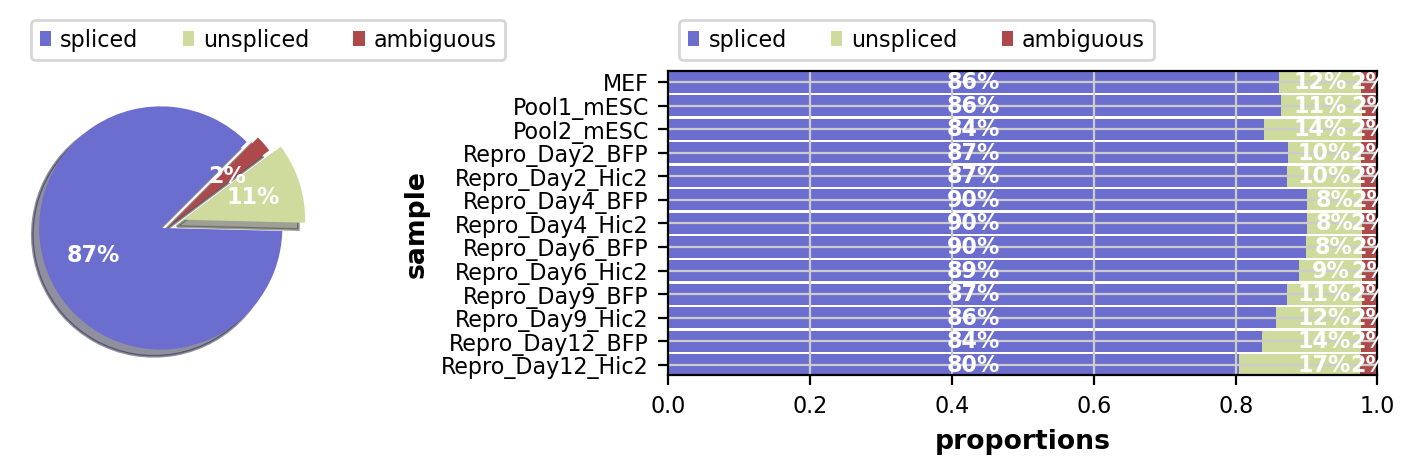

In [6]:
scvelo.pl.proportions(adata, groupby="sample")

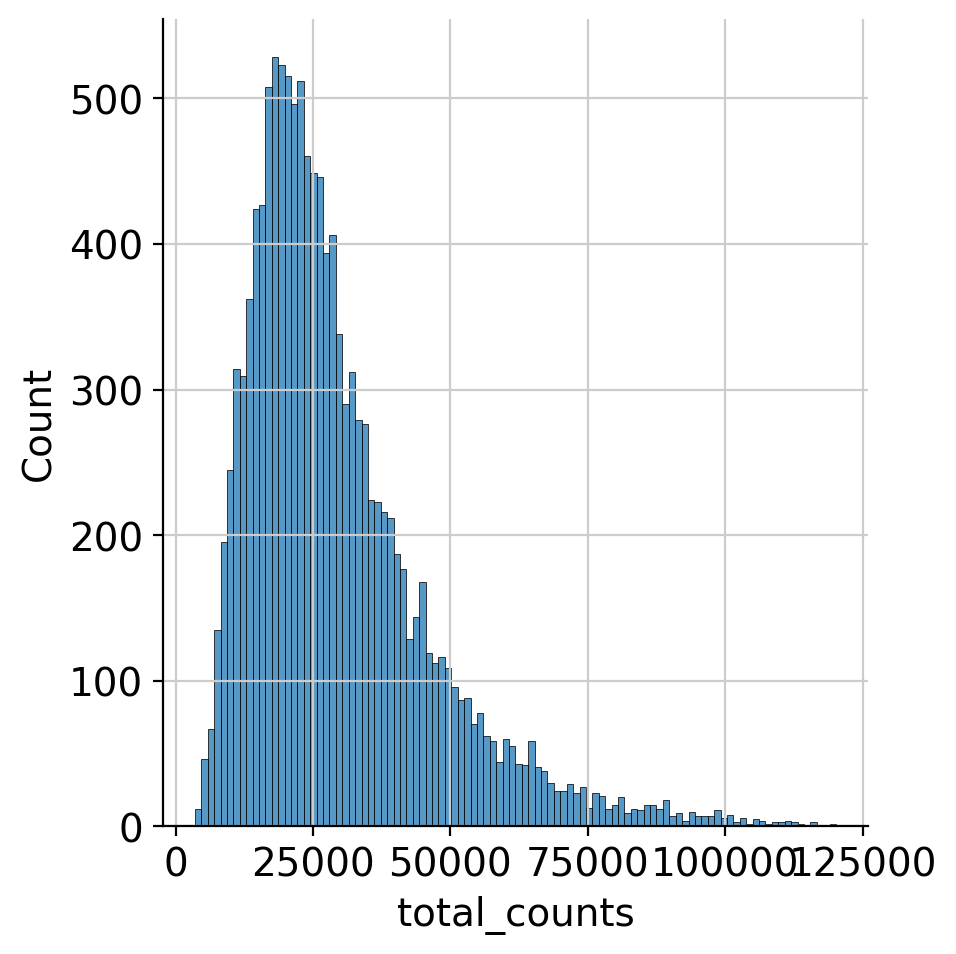

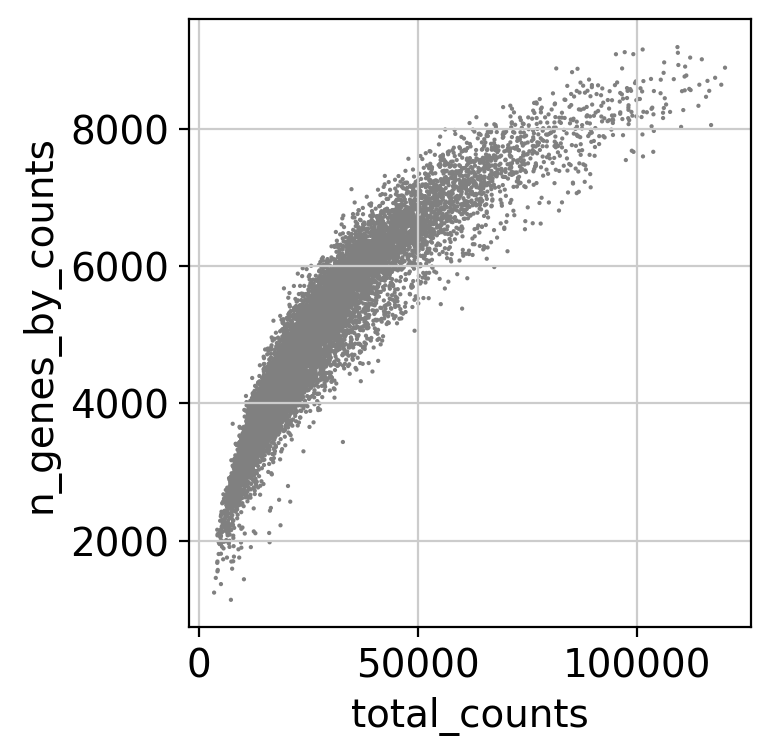

In [4]:
# Quality control

# Get mitochondrial genes
# adata.var["mt"] = adata.var_names.str.startswith("Mt-")
# scanpy.pp.calculate_qc_metrics(
#     adata, qc_vars=["mt"], inplace=True, percent_top=[], log1p=False
# )
# print("Mitochondrial genes:")
# print(adata.var_names[adata.var["mt"]])

scanpy.pp.calculate_qc_metrics(
    adata, inplace=True, percent_top=[], log1p=False
)
histogram = seaborn.displot(adata.obs["total_counts"], bins=100, kde=False)
scatter = scanpy.pl.scatter(adata, "total_counts", "n_genes_by_counts")

In [5]:
# Maybe do batch correction



In [6]:
# Filter and normalize
adata_velocity = adata.copy()

# Filter genes by spliced and unspliced counts and normalize
scvelo.pp.filter_and_normalize(adata_velocity, min_shared_counts=20, n_top_genes=2000)

print(f"Filtered Anndata object:\n{adata_velocity}")

Filtered out 26786 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.
Filtered Anndata object:
AnnData object with n_obs × n_vars = 12800 × 2000
    obs: 'barcode', 'sample', 'group', 'day', 'n_genes_by_counts', 'total_counts', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts'
    var: 'gene_names', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable'
    uns: 'log1p'
    obsm: 'X_umap'
    layers: 'ambiguous', 'any', 'spliced', 'unspliced'


/home/love/miniconda3/envs/masters_project/lib/python3.13/site-packages/scvelo/preprocessing/utils.py:705: DeprecationWarning: `log1p` is deprecated since scVelo v0.3.0 and will be removed in a future version. Please use `log1p` from `scanpy.pp` instead.
  log1p(adata)


In [7]:
# Compute first and second moments
scanpy.pp.neighbors(adata_velocity, use_rep="X_umap")
scvelo.pp.moments(adata_velocity, n_pcs=None, n_neighbors=None)

computing moments based on connectivities
    finished (0:00:01) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


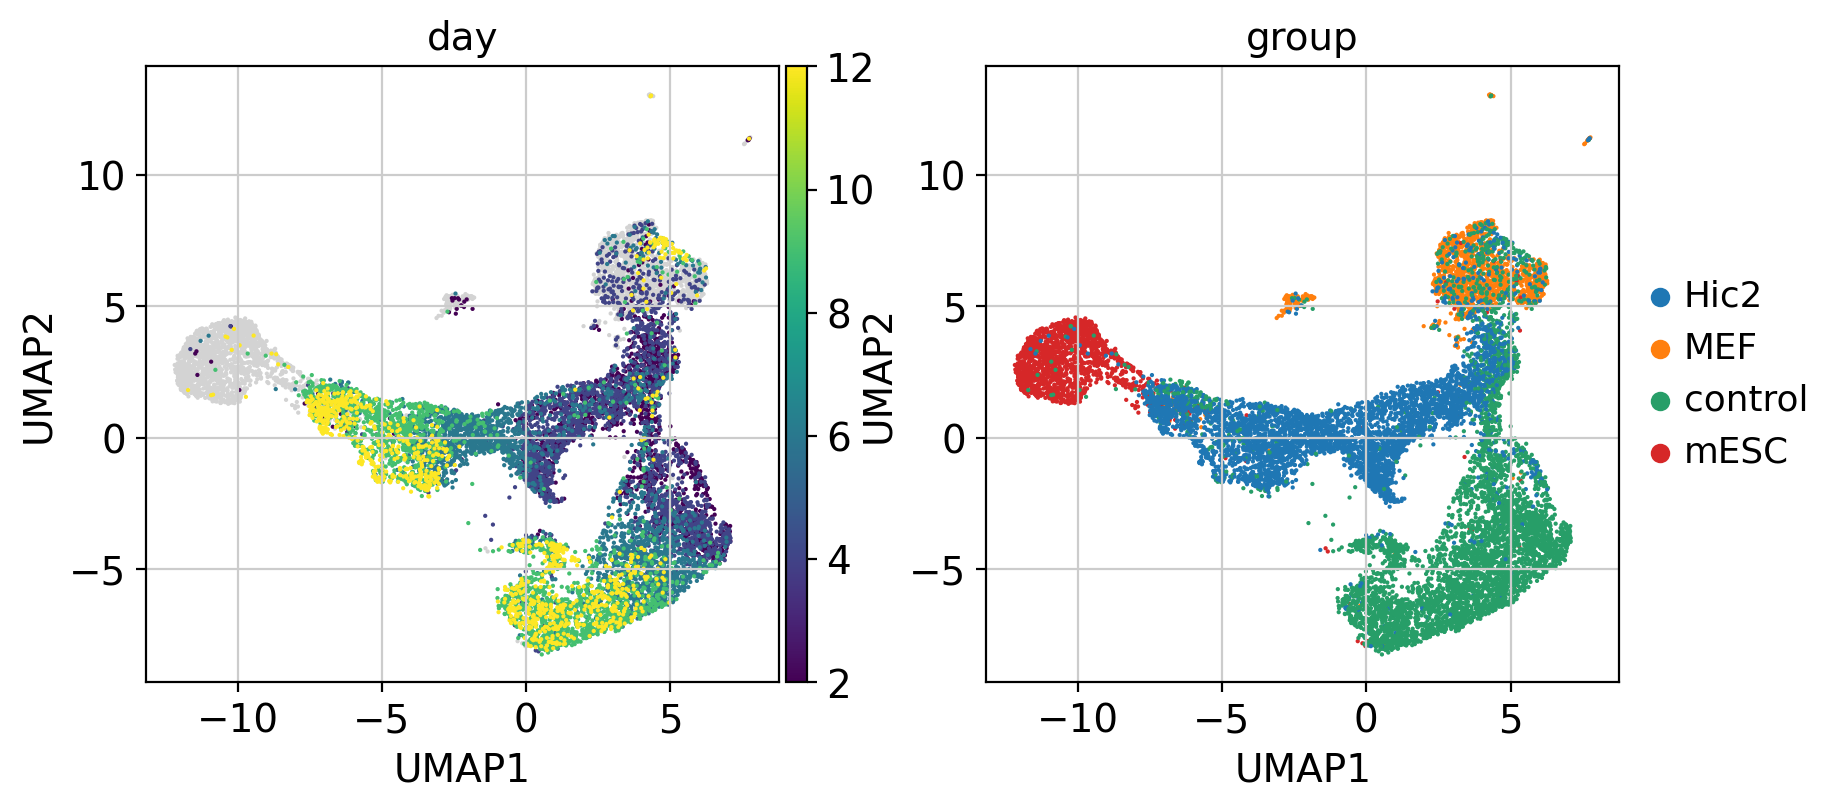

In [8]:
# Plot cells

# Convert day variable to float
adata_velocity.obs["day"] = adata_velocity.obs["day"].astype(float)
time_series_filter = ~adata_velocity.obs["group"].isin({"MEF", "mESC"})
adata_velocity.obs["day"].loc[~time_series_filter] = None

# Plot UMAP
axes_list = scanpy.pl.umap(adata_velocity, color=["day", "group"], show=False)
for ax in axes_list:
    ax.yaxis.set_major_locator(matplotlib.ticker.AutoLocator())
    ax.xaxis.set_major_locator(matplotlib.ticker.AutoLocator())

pyplot.show()

In [9]:
# Calculate EM velocities

scvelo.tl.recover_dynamics(adata_velocity, n_jobs=16)

recovering dynamics (using 16/16 cores)


  0%|          | 0/1467 [00:00<?, ?gene/s]

/home/love/miniconda3/envs/masters_project/lib/python3.13/multiprocessing/popen_fork.py:67: DeprecationWarning: This process (pid=7161) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
/home/love/miniconda3/envs/masters_project/lib/python3.13/site-packages/scanpy/_utils/__init__.py:33: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  from anndata import __version__ as anndata_version
/home/love/miniconda3/envs/masters_project/lib/python3.13/site-packages/scanpy/_utils/__init__.py:33: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  from anndata import __version__ as anndata_version
/home/love/miniconda3/envs/masters_project/lib/python3.13/site-packages/scanpy/_utils/__init__.py:33: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  from anndata import __version__ as anndata_version
/home/love/minic

    finished (0:09:36) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)


computing velocities


/home/love/miniconda3/envs/masters_project/lib/python3.13/site-packages/scvelo/tools/optimization.py:184: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  gamma[i] = np.linalg.pinv(A.T.dot(A)).dot(A.T.dot(y[:, i]))


    finished (0:00:03) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 15/16 cores)


  0%|          | 0/12800 [00:00<?, ?cells/s]

/home/love/miniconda3/envs/masters_project/lib/python3.13/multiprocessing/popen_fork.py:67: DeprecationWarning: This process (pid=7161) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()


    finished (0:00:05) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:01) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


/home/love/miniconda3/envs/masters_project/lib/python3.13/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/home/love/miniconda3/envs/masters_project/lib/python3.13/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/home/love/miniconda3/envs/masters_project/lib/python3.13/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/home/love/miniconda3/envs/masters

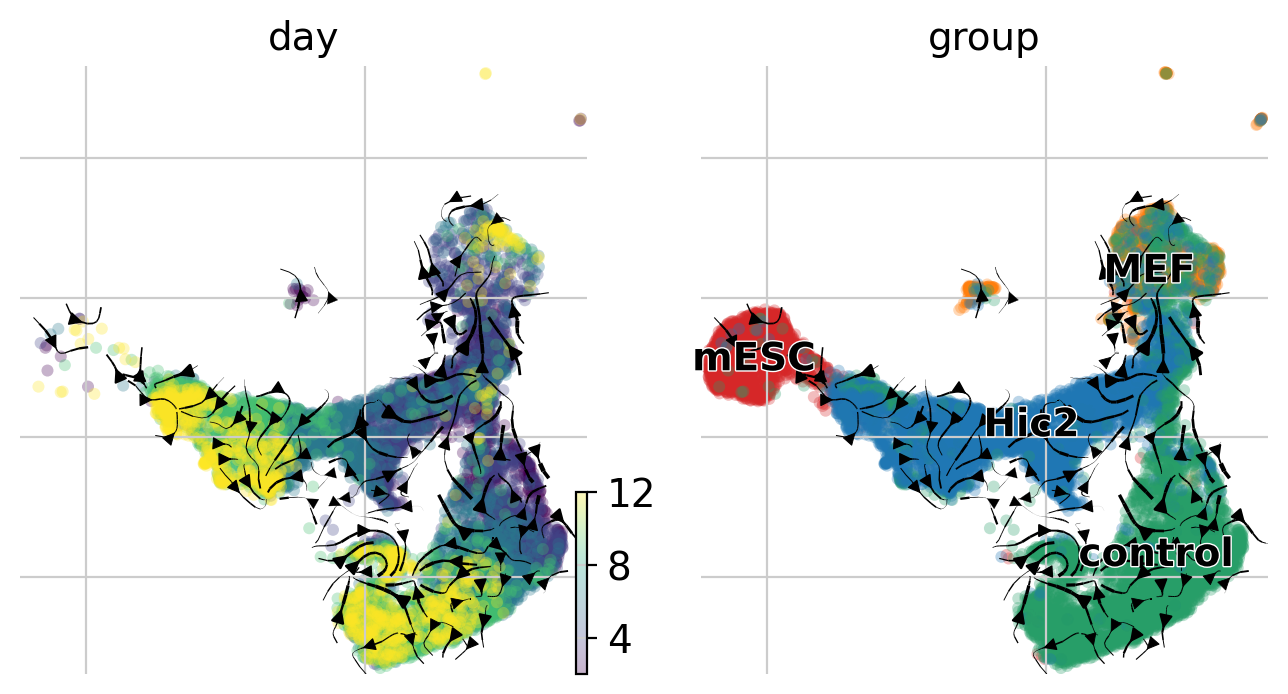

In [10]:
# Visualize EM velocities

scvelo.tl.velocity_graph(adata_velocity, n_jobs=15)
scvelo.pl.velocity_embedding_stream(adata_velocity, basis="umap", color=["day", "group"])

/home/love/miniconda3/envs/masters_project/lib/python3.13/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/home/love/miniconda3/envs/masters_project/lib/python3.13/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/home/love/miniconda3/envs/masters_project/lib/python3.13/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/home/love/miniconda3/envs/masters

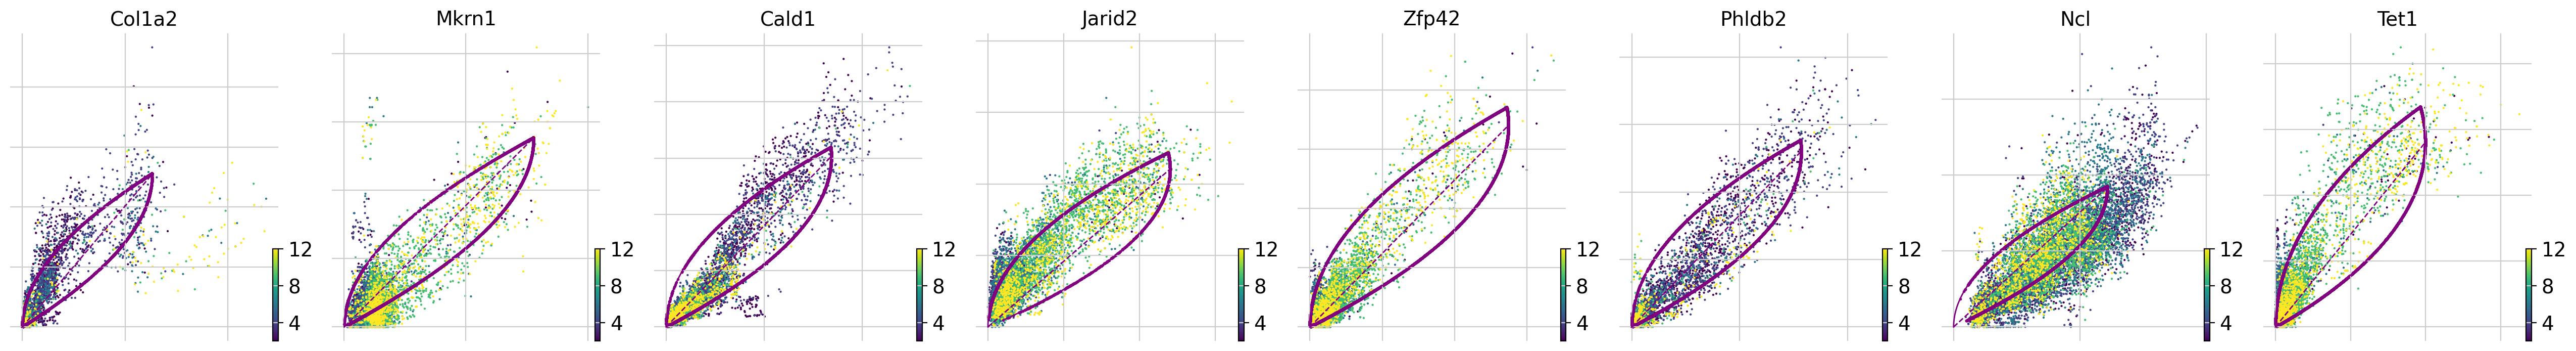

In [11]:
# Plot top genes
top_genes = adata_velocity.var["fit_likelihood"].sort_values(ascending=False).index
scvelo.pl.scatter(adata_velocity, basis=top_genes[:8], color=["day"], frameon=False)

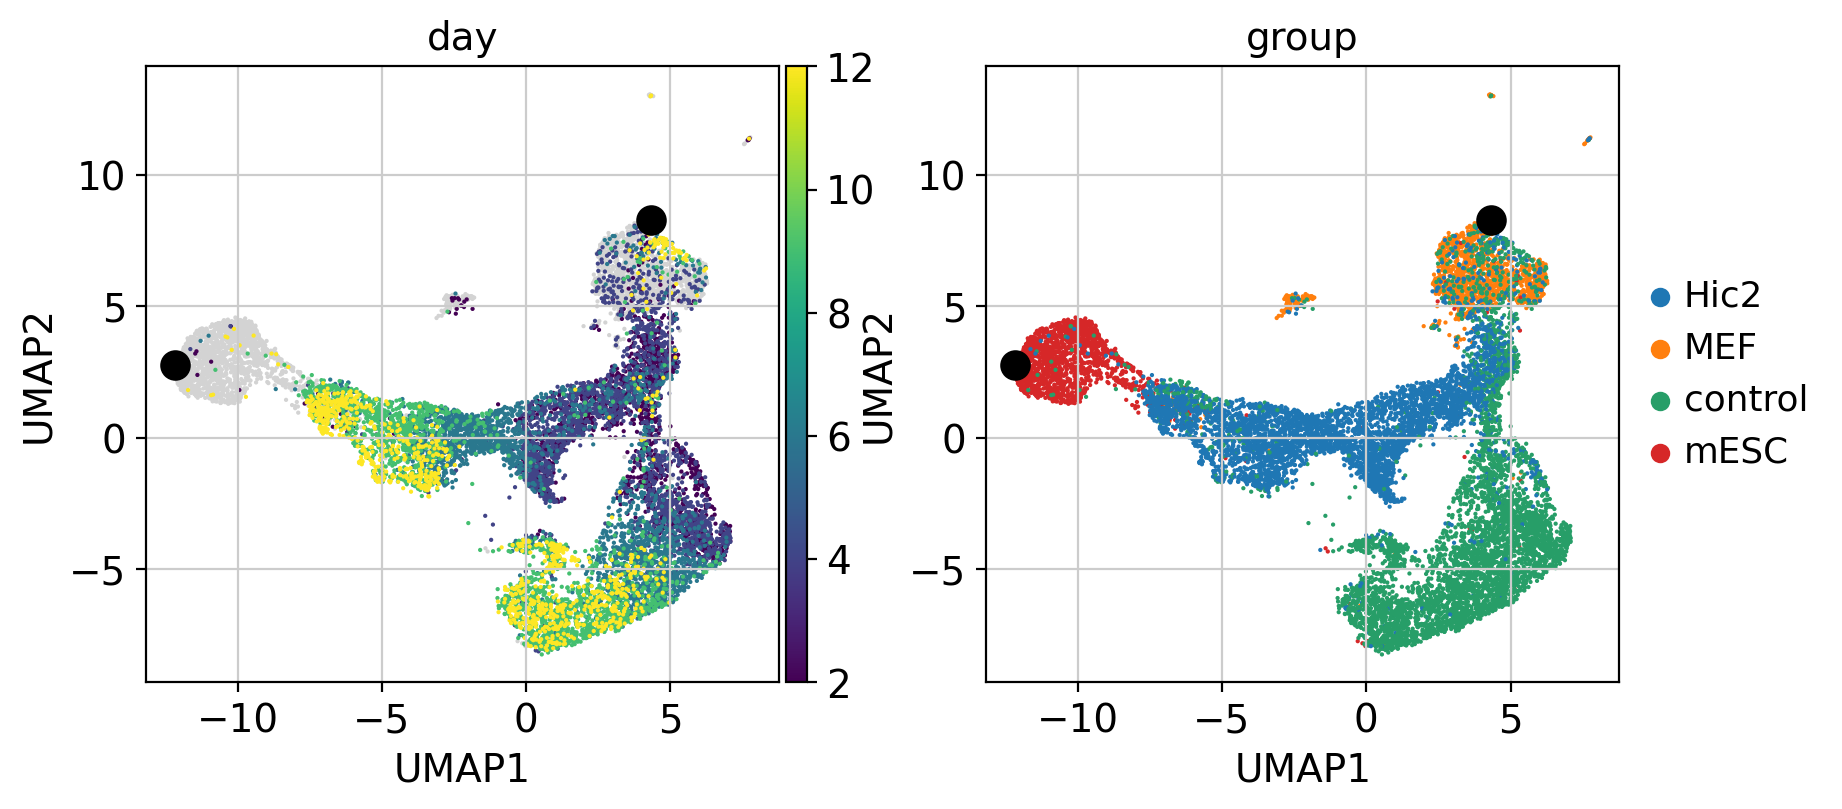

In [27]:
# Find good root and end cells

# Find root
root_filter = (adata_velocity.obs["group"]=="MEF")*(adata_velocity.obsm["X_umap"][:,1]<10)
# Use MEF cell with largest UMAP2, ignoring outliers with >10
root_index = numpy.argmax(adata_velocity[root_filter].obsm["X_umap"][:,1])
root_barcode = adata_velocity[root_filter].obs.index[root_index]
adata_velocity.obs["manual_root"] = False
adata_velocity.obs["manual_root"].loc[root_barcode] = True

# Find end
end_filter = adata_velocity.obs["group"]=="mESC"
# Use mESC cell with smallest UMAP1
end_index = numpy.argmin(adata_velocity[end_filter].obsm["X_umap"][:,0])
end_barcode = adata_velocity[end_filter].obs.index[end_index]
adata_velocity.obs["manual_end"] = False
adata_velocity.obs["manual_end"].loc[end_barcode] = True

# Plot UMAP
axes_list = scanpy.pl.umap(adata_velocity, color=["day", "group"], show=False)
for ax in axes_list:
    ax.scatter(*adata_velocity[adata_velocity.obs["manual_end"]].obsm["X_umap"][0], marker="o", s=100, color="black")
    ax.scatter(*adata_velocity[adata_velocity.obs["manual_root"]].obsm["X_umap"][0], marker="o", s=100, color="black")
    ax.yaxis.set_major_locator(matplotlib.ticker.AutoLocator())
    ax.xaxis.set_major_locator(matplotlib.ticker.AutoLocator())

pyplot.show()

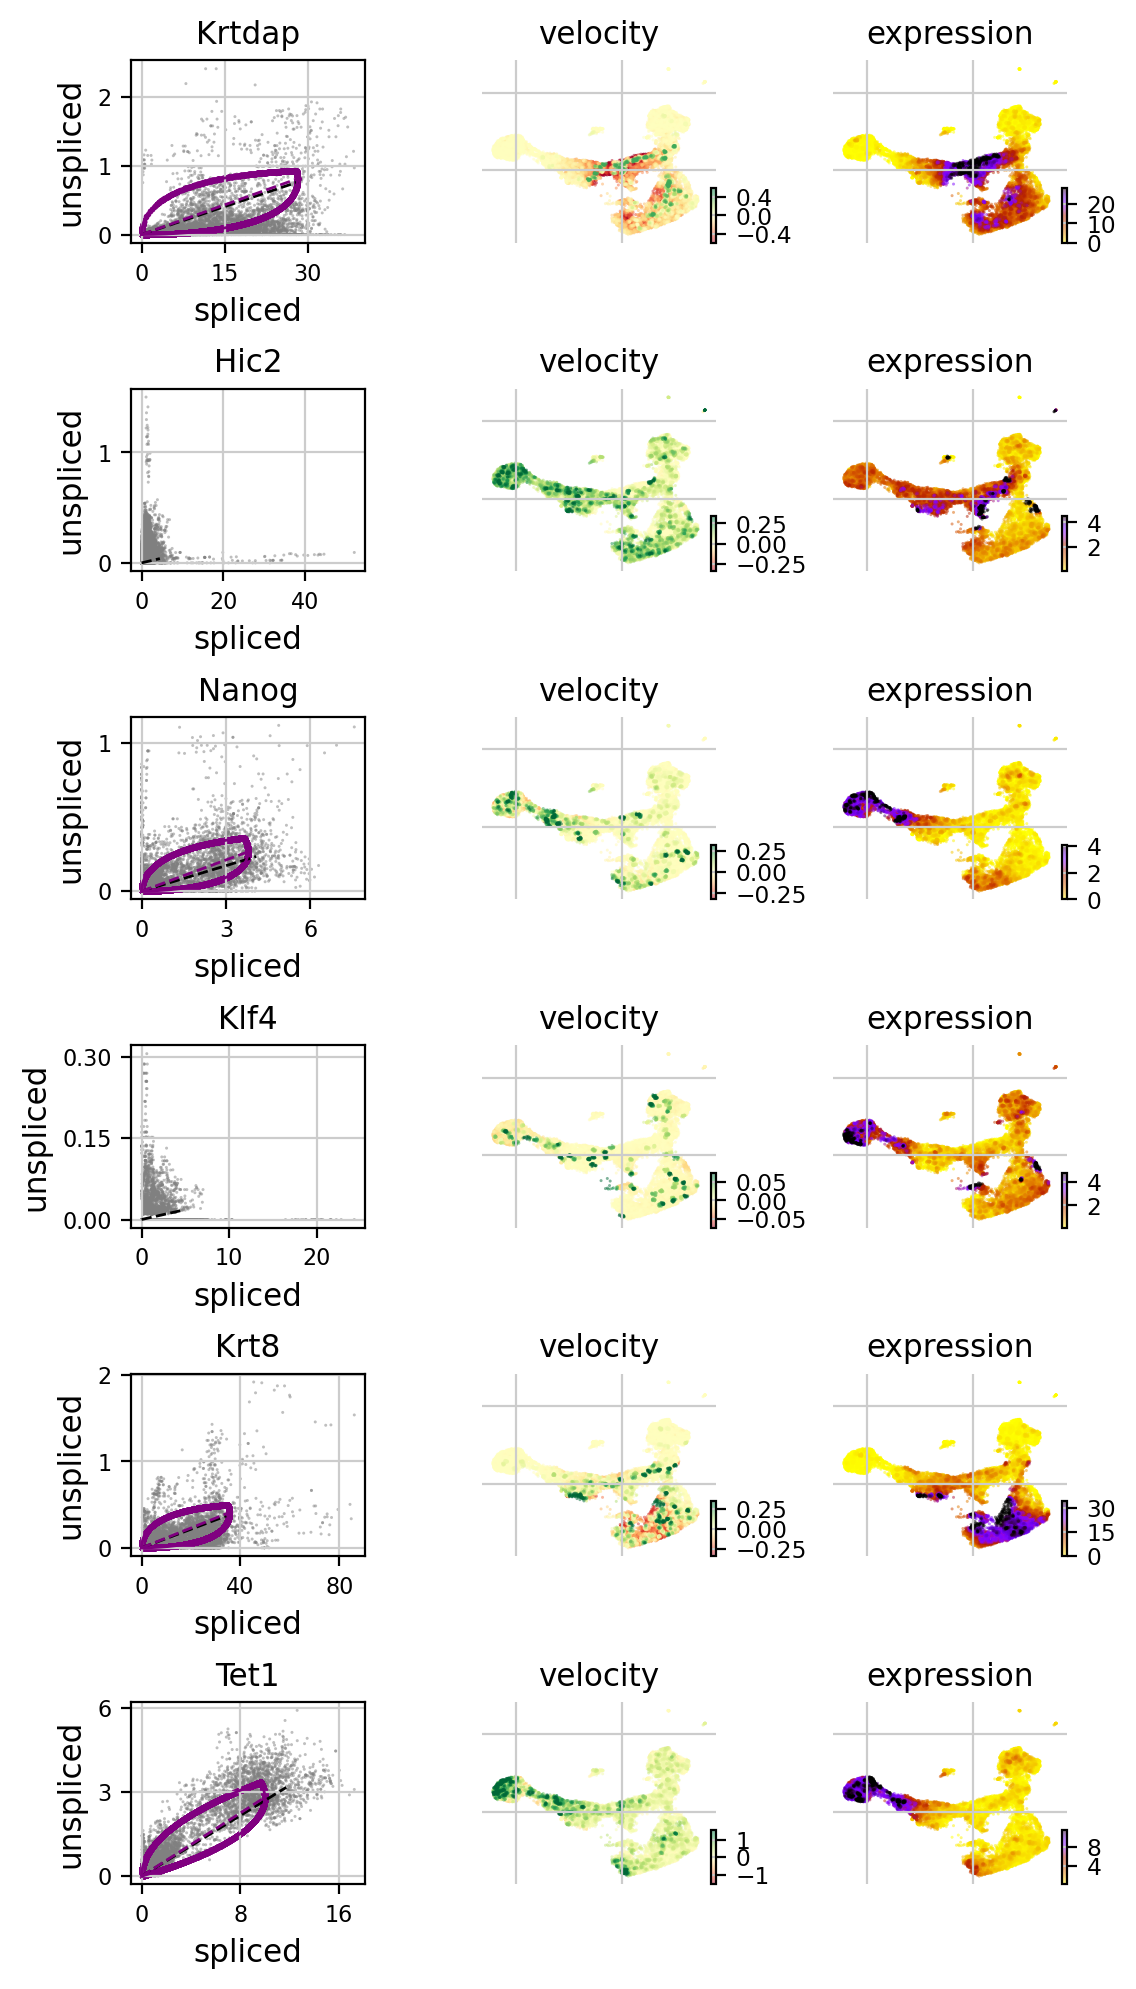

In [ ]:
# Plot important genes
model_genes = ["Krtdap", "Hic2", "Nanog", "Klf4", "Krt8", "Tet1"]
scvelo.pl.velocity(adata_velocity, var_names=model_genes)

computing latent time using manual_root, manual_end as prior
    finished (0:00:01) --> added 
    'latent_time', shared time (adata.obs)


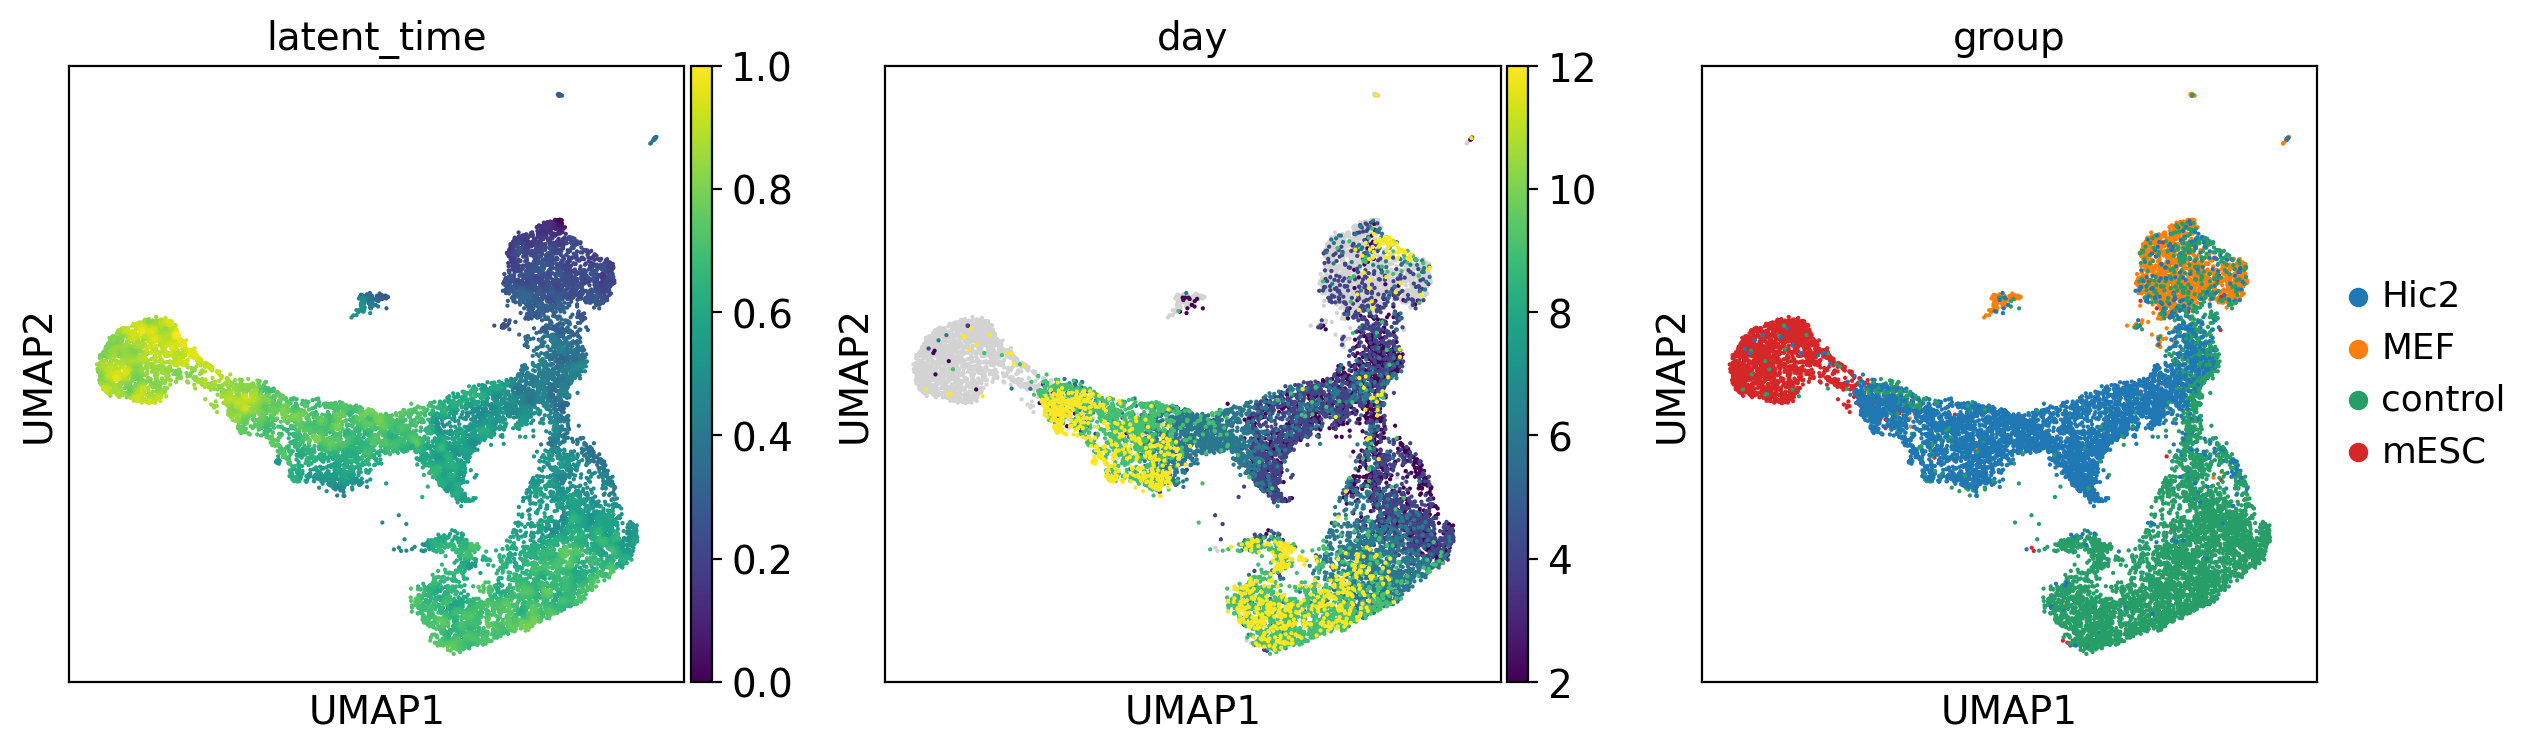

In [35]:
# Latent time

# Use that column as root_key
scvelo.tl.recover_latent_time(adata_velocity, root_key="manual_root", end_key="manual_end")

# Plot velocities colored by latent time
scanpy.pl.umap(adata_velocity, color=["latent_time", "day", "group"])


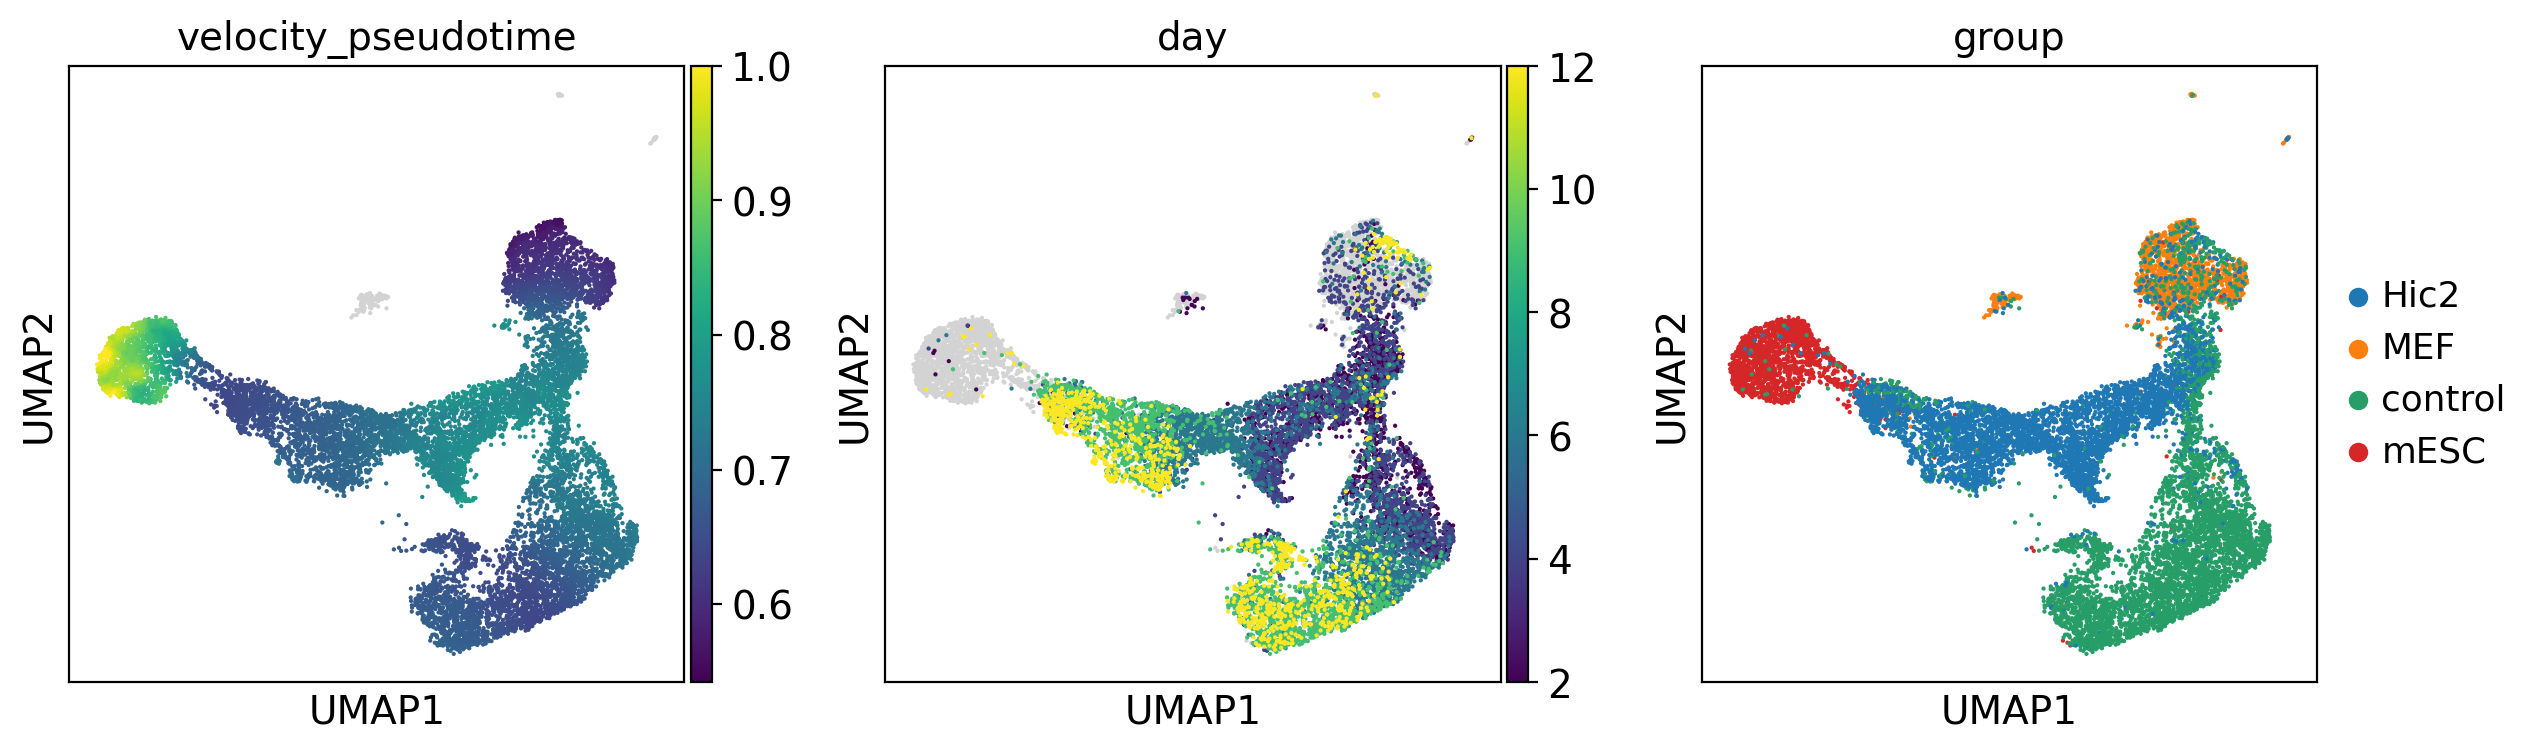

In [34]:
# Pseudotime
global_root_index = numpy.argmax(adata_velocity.obs.index == root_barcode)
global_end_index = numpy.argmax(adata_velocity.obs.index == end_barcode)
# global_root_index = adata_velocity[root_barcode].obs
scvelo.tl.velocity_pseudotime(adata_velocity, root_key=global_root_index, end_key=global_end_index)
scanpy.pl.umap(adata_velocity, color=["velocity_pseudotime", "day", "group"])

In [36]:
# Save analyzed adata
adata_velocity.write_h5ad(
    "RNA Sequencing Data/velocity_adata.h5ad",
    compression=hdf5plugin.FILTERS["zstd"]
)